# Tarea 2
## Francisco Javier Peralta Ramírez

In [183]:
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm


import numpy as np
import sympy as sp
from functools import reduce

import warnings
sp.init_printing()
warnings.filterwarnings('ignore')

El algoritmo de regresión logistica es un clasificador binario para clases linealmente separables. La idea del algoritmo es poner una sigmoide sobre los datos de tal modo que el valor de cada dato, al evaluarse sobre la sigmoide representa la probabilidad de que pertenezca a la clase 1 es decir $P( Y = 1 | X = x ) $. La funcion sigmoide es:

$$ \phi(x) = \frac{1}{1 + e^{-z}}$$

Esta función tiene la siguiente forma en $\mathbb{R}^1$

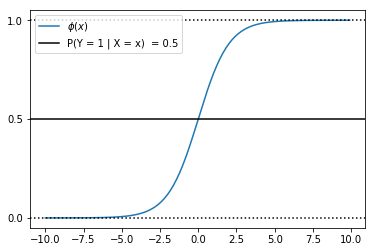

In [48]:
def sigmoid(x, lib=np):
    return 1/(1 + lib.exp(-x))
v = np.arange( -10, 10, 0.1)
plt.plot( v, sigmoid( v) , label="$\phi(x)$")
plt.axhline(0.0, ls='dotted', color='k')
plt.axhline(1.0, ls='dotted', color='k')
plt.axhline(0.5, color='k', label="P(Y = 1 | X = x)  = 0.5")
plt.yticks([0, 0.5, 1])
plt.legend()
plt.show()

Consideremos el caso simple de separar datos de dos Gaussianas, centramos los datos para acelerar la convergencia de nuestros algoritmos.

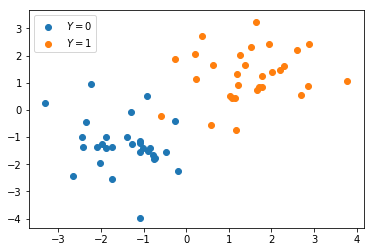

[-7.40148683e-18  4.47789953e-16]


In [214]:
n_samples = 30
x1 = np.random.multivariate_normal(np.array([0,0]), np.array([[1,0], [0, 1]]), n_samples)
x2 = np.random.multivariate_normal(np.array([3,3]), np.array([[1,0], [0, 1]]), n_samples)

x = np.append(x1, x2, axis = 0)
x = x - x.mean(axis=0) #centramos los datos para acelerar la convergencia
y = np.append([0] * len(x1) , [1] * len(x2)) # creamos nuestro vector de Y

plt.scatter(x[:n_samples,0], x[:n_samples,1] , label = "$Y = 0$")
plt.scatter(x[n_samples:,0], x[n_samples:,1] , label = "$Y = 1$")
plt.legend()
plt.show()

print(x.mean(axis=0))

Podemos hacer el ajuste de esta sigmoide minimizando el error de clasificación

$$ \min_{w}F(w) = \frac{1}{2} \sum_{i=1}^{m} (y_i - \phi(\mathbf{w}^T\mathbf{x}_i)^2 $$

donde $\mathbf{w}$ es un vector de pesos y $\mathbf{x}_i$ es nuestra variable en $\mathbb{R}^n$. Esto lo podemos resolver con el métdo de Levenberg-Marquardt ya que este sólo nos pide el Jacbobiano (primera derivada). En cada iteración del algoritmo LM se resuelve

$$ \min_{p} \frac{1}{2} ||J_kp+r_k||^2 \,\,\,\,\, ||p|| \leq \delta_k$$

donde $r_i = y_i - \phi(\mathbf{w}^T\mathbf{x}_i)$

In [215]:
n = len(x)
def logistic_function(x, w, lib=np):
    v = w[0]
    for i in range(len(x)):
        v += w[i+1] * x[i]
    return sigmoid(v, lib)
def R_sigmoid(y, x, w, lib=np):
    return logistic_function(x, w, lib=lib) - y

def jacobiano_sigmoid(f, y, x, w):
    w_s = sp.symbols("w0:{}".format(len(w)))
    x_s = sp.symbols("x0:{}".format(len(w) - 1))
    y_s = sp.Symbol("y")
    mtx = sp.Matrix([f( y_s , x_s, w_s , lib=sp)]) #el reduce nos da la suma de todas las w[i]
    jac = mtx.jacobian(w_s)
    jac_f  = [sp.lambdify((x_s + w_s), jac[i]) for i in range(len(w))]
    def __do_grad(w):
        jac_eval = [ [jac_fn(*xi, *w) for jac_fn in jac_f] for xi in x]
        return np.array(jac_eval)
    return __do_grad

jf = jacobiano_sigmoid(R_sigmoid, y, x, w)
def max_diag(A): #valor maximo en diagonal de matriz cuadrada
    l = A[0,0]
    for i in range(1, len(A)):
        l = A[i,i] if(A[i,i] > l) else l
    return l

In [216]:
w = np.array([0, 1, 1])
v = 1.2
toler = 1E-10
def R(y, x, w, lib=np):
    return np.array([ R_sigmoid(y[i], x[i], w, lib=lib) for i in range(len(x))])
jf = jacobiano_sigmoid(R_sigmoid, y, x, w)

def LM(R, J, x, y, w):
    k = 0
    r = R(y, x, w)
    j = J(w)
    JJ = j.T@j
    l = max_diag(JJ)
    norm_sq_r = r.T @ r
    b = j.T @r
    while np.linalg.norm( b ) > toler and k < 1000:
        A = JJ + np.identity(JJ.shape[0]) * l
        p = np.linalg.solve(A, -b)
        nw = w + p
        nr = R(y, x, w)
        norm_sq_nr = nr.T @ nr
        if( norm_sq_nr <= norm_sq_r):
            norm_sq_r = norm_sq_nr
            r = nr
            w = nw
            l /= v
            j = J(w)
            JJ = j.T@j
            b = j.T @r
        else:
            l *= v
        k += 1
    return w
w = LM(R, jf, x, y, np.array([0, 1, 1]))

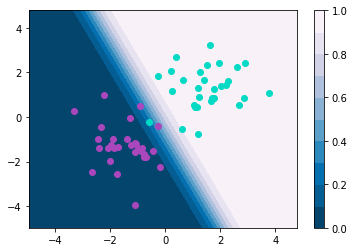

In [235]:
N = 100
# w = np.array([0 ,  1, 1])
x_v = np.linspace(x.min()-1, x.max()+1, N)
y_v = np.linspace(x.min()-1, x.max()+1, N)
X_v, Y_v = np.meshgrid(x_v, y_v)
XX = np.array([X_v.ravel(), Y_v.ravel()]).T
Z = np.array([logistic_function(xi, w) for xi in XX])
Z = Z.reshape(X_v.shape)
cs = plt.contourf(X_v, Y_v, Z, locator=ticker.LinearLocator(), cmap=cm.PuBu_r)
plt.scatter(x[:n_samples,0], x[:n_samples,1] , label = "$Y = 0$", color = '#AB47BC')
plt.scatter(x[n_samples:,0], x[n_samples:,1] , label = "$Y = 1$", color = '#03DAc6')
cbar = plt.colorbar(cs)